In [3]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

COLORS = ["darkorange","royalblue","slategrey"]

In [4]:
cwd = os.getcwd()
print(cwd)

/home/alain/Desktop/ai-workflow-capstone-master


In [5]:
def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)

In [6]:
def convert_to_ts(df_orig, country=None):
    """
    given the original DataFrame (fetch_data())
    return a numerically indexed time-series DataFrame 
    by aggregating over each day
    """

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month,stop_month,dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    return(df_time)

In [7]:
def fetch_ts(data_dir, clean=False):
    """
    convenience function to read in new data
    uses csv to load quickly
    use clean=True when you want to re-create the files
    """

    ts_data_dir = os.path.join(data_dir,"ts-data")
    
    if clean:
        shutil.rmtree(ts_data_dir)
    if not os.path.exists(ts_data_dir):
        os.mkdir(ts_data_dir)

    ## if files have already been processed load them        
    if len(os.listdir(ts_data_dir)) > 0:
        print("... loading ts data from files")
        return({re.sub("\.csv","",cf)[3:]:pd.read_csv(os.path.join(ts_data_dir,cf)) for cf in os.listdir(ts_data_dir)})

    ## get original data
    print("... processing data for loading")
    df = fetch_data(data_dir)

    ## find the top ten countries (wrt revenue)
    table = pd.pivot_table(df,index='country',values="price",aggfunc='sum')
    table.columns = ['total_revenue']
    table.sort_values(by='total_revenue',inplace=True,ascending=False)
    top_ten_countries =  np.array(list(table.index))[:10]

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    countries = [os.path.join(data_dir,"ts-"+re.sub("\s+","_",c.lower()) + ".csv") for c in top_ten_countries]

    ## load the data
    dfs = {}
    dfs['all'] = convert_to_ts(df)
    for country in top_ten_countries:
        country_id = re.sub("\s+","_",country.lower())
        file_name = os.path.join(data_dir,"ts-"+ country_id + ".csv")
        dfs[country_id] = convert_to_ts(df,country=country)

    ## save the data as csvs    
    for key, item in dfs.items():
        item.to_csv(os.path.join(ts_data_dir,"ts-"+key+".csv"),index=False)
        
    return(dfs)

In [131]:
def engineer_features(df,training=True):
    """
    for any given day the target becomes the sum of the next days revenue
    for that day we engineer several features that help predict the summed revenue
    
    the 'training' flag will trim data that should not be used for training
    when set to false all data will be returned

    """
    #print(df.head(10))
    #print(df.index)
    df['date'] = df.index
    #print(df.head(10))
    ## extract dates
    dates = df['date'].values.copy()
    dates = dates.astype('datetime64[D]')

    ## engineer some features
    eng_features = defaultdict(list)
    previous =[7, 14, 28, 70]  #[7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
    y = np.zeros(dates.size)
    for d,day in enumerate(dates):

        ## use windows in time back from a specific date
        for num in previous:
            current = np.datetime64(day, 'D') 
            prev = current - np.timedelta64(num, 'D')
            mask = np.in1d(dates, np.arange(prev,current,dtype='datetime64[D]'))
            eng_features["previous_{}".format(num)].append(df[mask]['revenue'].sum())

        ## get get the target revenue    
        plus_30 = current + np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(current,plus_30,dtype='datetime64[D]'))
        y[d] = df[mask]['revenue'].sum()

        ## attempt to capture monthly trend with previous years data (if present)
        start_date = current - np.timedelta64(365,'D')
        stop_date = plus_30 - np.timedelta64(365,'D')
        mask = np.in1d(dates, np.arange(start_date,stop_date,dtype='datetime64[D]'))
        eng_features['previous_year'].append(df[mask]['revenue'].sum())

        ## add some non-revenue features
        minus_30 = current - np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(minus_30,current,dtype='datetime64[D]'))
        eng_features['recent_invoices'].append(df[mask]['unique_invoices'].mean())
        eng_features['recent_views'].append(df[mask]['total_views'].mean())

    X = pd.DataFrame(eng_features)
    ## combine features in to df and remove rows with all zeros
    X.fillna(0,inplace=True)
    mask = X.sum(axis=1)>0
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)

    if training == True:
        ## remove the last 30 days (because the target is not reliable)
        mask = np.arange(X.shape[0]) < np.arange(X.shape[0])[-30]
        X = X[mask]
        y = y[mask]
        dates = dates[mask]
        X.reset_index(drop=True, inplace=True)
    
    return(X,y,dates)

In [ ]:
X_Rev30, y_rev30, mydates = engineer_features(myts,training=False)

In [138]:
print(X_Rev30.head(10))
print(y_rev30[:20])

   previous_7  previous_14  previous_28  previous_70  previous_year  \
0    14450.54     14450.54     14450.54     14450.54            0.0   
1    27862.50     27862.50     27862.50     27862.50            0.0   
2    41152.75     41152.75     41152.75     41152.75            0.0   
3    50840.03     50840.03     50840.03     50840.03            0.0   
4    52283.29     52283.29     52283.29     52283.29            0.0   
5    58716.23     58716.23     58716.23     58716.23            0.0   
6    71853.73     71853.73     71853.73     71853.73            0.0   
7    66870.20     81320.74     81320.74     81320.74            0.0   
8    64726.78     92589.28     92589.28     92589.28            0.0   
9    62413.13    103565.88    103565.88    103565.88            0.0   

   recent_invoices  recent_views  
0         5.928571    537.392857  
1        10.310345   1007.103448  
2        14.966667   1499.066667  
3        18.533333   1916.533333  
4        19.600000   2026.966667  
5       

In [9]:
if __name__ == "__main__":

    run_start = time.time() 
    data_dir = os.path.join(cwd,"data","cs-train")
    print(data_dir)
    print("...fetching data")
    mydf = fetch_data(data_dir)
    ts_all = fetch_ts(data_dir,clean=False)

    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("load time:", "%d:%02d:%02d"%(h, m, s))

    for key,item in ts_all.items():
        print(key,item.shape)

/home/alain/Desktop/ai-workflow-capstone-master/data/cs-train
...fetching data
... loading ts data from files
load time: 0:00:13
all (607, 7)
france (607, 7)
norway (577, 7)
united_kingdom (607, 7)
netherlands (607, 7)
portugal (607, 7)
germany (607, 7)
spain (607, 7)
eire (607, 7)
hong_kong (426, 7)
singapore (456, 7)


In [10]:
mydf.head()


country  customer_id  day invoice  month  price stream_id  \
0  United Kingdom      16393.0   28  489536     11   2.25     21581   
1  United Kingdom      13085.0   28  489434     11   6.75    79323P   
2  United Kingdom      13085.0   28  489434     11   6.75    79323W   
3  United Kingdom      13085.0   28  489434     11   2.10     22041   
4  United Kingdom      13085.0   28  489434     11   1.25     21232   

   times_viewed  year invoice_date  
0             4  2017   2017-11-28  
1            12  2017   2017-11-28  
2            12  2017   2017-11-28  
3            21  2017   2017-11-28  
4             5  2017   2017-11-28

In [11]:
myts = convert_to_ts(mydf, country=None)
myts.head()

date  purchases  unique_invoices  unique_streams  total_views  \
0 2017-11-01          0                0               0            0   
1 2017-11-02          0                0               0            0   
2 2017-11-03          0                0               0            0   
3 2017-11-04          0                0               0            0   
4 2017-11-05          0                0               0            0   

  year_month  revenue  
0    2017-11      0.0  
1    2017-11      0.0  
2    2017-11      0.0  
3    2017-11      0.0  
4    2017-11      0.0

In [12]:
myts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             607 non-null    datetime64[ns]
 1   purchases        607 non-null    int64         
 2   unique_invoices  607 non-null    int64         
 3   unique_streams   607 non-null    int64         
 4   total_views      607 non-null    int64         
 5   year_month       607 non-null    object        
 6   revenue          607 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 33.3+ KB


In [13]:
myts.describe()

purchases  unique_invoices  unique_streams   total_views  \
count   607.000000       607.000000      607.000000    607.000000   
mean   1273.464580        66.919275      658.074135   6651.255354   
std    1015.758467        47.871442      411.048951   4990.636140   
min       0.000000         0.000000        0.000000      0.000000   
25%     634.500000        27.000000      435.500000   2681.500000   
50%    1293.000000        70.000000      764.000000   7080.000000   
75%    1752.500000        98.000000      934.000000   9368.000000   
max    7756.000000       219.000000     1596.000000  29374.000000   

             revenue  
count     607.000000  
mean     6131.698394  
std     10395.054288  
min    -44990.049000  
25%      1805.780000  
50%      4778.020000  
75%      7640.235000  
max    170304.180000

In [14]:
myts.max(0)

date               2019-06-30 00:00:00
purchases                         7756
unique_invoices                    219
unique_streams                    1596
total_views                      29374
year_month                     2019-06
revenue                         170304
dtype: object

In [15]:
myts.min(0)

date               2017-11-01 00:00:00
purchases                            0
unique_invoices                      0
unique_streams                       0
total_views                          0
year_month                     2017-11
revenue                         -44990
dtype: object

In [16]:
myts.nunique(0)

date               607
purchases          427
unique_invoices    141
unique_streams     358
total_views        460
year_month          20
revenue            469
dtype: int64

In [17]:
grouped = myts.groupby("date")
grouped.size()

date
2017-11-01    1
2017-11-02    1
2017-11-03    1
2017-11-04    1
2017-11-05    1
             ..
2019-06-26    1
2019-06-27    1
2019-06-28    1
2019-06-29    1
2019-06-30    1
Length: 607, dtype: int64

In [18]:
pd.pivot_table(mydf, values = 'price', index=['country'],aggfunc=np.sum).reset_index()


country         price
0              Australia  6.872630e+03
1                Austria  3.390890e+03
2                Bahrain  4.394900e+02
3                Belgium  1.119061e+04
4                Bermuda  8.470000e+01
5                 Brazil  2.563100e+02
6                 Canada  1.053100e+03
7        Channel Islands  7.610120e+03
8                 Cyprus  4.976300e+03
9         Czech Republic  3.183000e+01
10               Denmark  1.818510e+03
11                  EIRE  1.070692e+05
12    European Community  2.940500e+02
13               Finland  3.364650e+03
14                France  4.056514e+04
15               Germany  4.927182e+04
16                Greece  2.437370e+03
17             Hong Kong  1.445257e+04
18               Iceland  5.098600e+02
19                Israel  4.575900e+02
20                 Italy  5.910190e+03
21                 Japan  1.083120e+03
22                 Korea  1.502400e+02
23               Lebanon  3.586100e+02
24             Lithuania  4.944100e+02
25                 Malta  6.085340e+03
26           Netherlands  1.232280e+04
27               Nigeria  1.092800e+02
28                Norway  3.849475e+04
29                Poland  1.510710e+03
30              Portugal  1.352867e+04
31                   RSA  3.105750e+03
32          Saudi Arabia  2.411000e+01
33             Singapore  1.317592e+04
34                 Spain  1.604099e+04
35                Sweden  7.876760e+03
36           Switzerland  9.284050e+03
37              Thailand  2.279700e+02
38                   USA  1.185100e+03
39  United Arab Emirates  2.400210e+03
40        United Kingdom  3.521514e+06
41           Unspecified  3.045360e+03
42           West Indies  1.227700e+02

In [20]:
pd.pivot_table(mydf, values = 'price', index=['invoice_date']).reset_index()

invoice_date      price
0     2017-11-28   4.483568
1     2017-11-29   4.092756
2     2017-11-30   4.427132
3     2017-12-01   3.785572
4     2017-12-02   3.590199
..           ...        ...
490   2019-07-26   3.211264
491   2019-07-28   2.478568
492   2019-07-29   3.645450
493   2019-07-30  11.961110
494   2019-07-31   3.182647

[495 rows x 2 columns]

In [21]:
mydf.groupby(["country"]).sum()

customer_id       day    month         price  \
country                                                               
Australia             1.927165e+07     25288     9595  6.872630e+03   
Austria               8.969334e+06     12578     5063  3.390890e+03   
Bahrain               7.288970e+05      2546      600  4.394900e+02   
Belgium               2.698339e+07     34031    12907  1.119061e+04   
Bermuda               0.000000e+00       510      102  8.470000e+01   
Brazil                1.199170e+06      1500      686  2.563100e+02   
Canada                3.711293e+06      2993     1720  1.053100e+03   
Channel Islands       1.906329e+07     21300     8653  7.610120e+03   
Cyprus                1.127679e+07     12496     6055  4.976300e+03   
Czech Republic        2.172770e+05       433       36  3.183000e+01   
Denmark               7.983399e+06      7821     4176  1.818510e+03   
EIRE                  1.781244e+08    214425    89337  1.070692e+05   
European Community    9.215880e+05       823      373  2.940500e+02   
Finland               9.380275e+06     12301     3802  3.364650e+03   
France                1.245792e+08    139287    62335  4.056514e+04   
Germany               1.683921e+08    203006    81741  4.927182e+04   
Greece                9.267245e+06      6656     4139  2.437370e+03   
Hong Kong             0.000000e+00      4173     1114  1.445257e+04   
Iceland               2.407665e+06      2899     1531  5.098600e+02   
Israel                1.506136e+06      2222      876  4.575900e+02   
Italy                 1.332039e+07     17641     6997  5.910190e+03   
Japan                 6.560219e+06      6072     3075  1.083120e+03   
Korea                 8.043410e+05      1248      663  1.502400e+02   
Lebanon               5.743800e+05      1216      163  3.586100e+02   
Lithuania             2.897748e+06      1045     1837  4.944100e+02   
Malta                 3.500476e+06      4636     1329  6.085340e+03   
Netherlands           5.675384e+07     71766    24961  1.232280e+04   
Nigeria               4.710600e+05       574      255  1.092800e+02   
Norway                1.002374e+07     12753     7108  3.849475e+04   
Poland                5.462688e+06      6935     2739  1.510710e+03   
Portugal              2.212917e+07     27623    13032  1.352867e+04   
RSA                   8.057400e+05      3217      525  3.105750e+03   
Saudi Arabia          1.256500e+05       217       20  2.411000e+01   
Singapore             3.950640e+06      3578     1702  1.317592e+04   
Spain                 3.335718e+07     37596    15379  1.604099e+04   
Sweden                1.543299e+07     17258     7288  7.876760e+03   
Switzerland           2.876593e+07     42432    14810  9.284050e+03   
Thailand              9.476440e+05       312      522  2.279700e+02   
USA                   3.371225e+06      4042     1331  1.185100e+03   
United Arab Emirates  5.322536e+06      6105     2738  2.400210e+03   
United Kingdom        8.770331e+09  11294245  4967307  3.521514e+06   
Unspecified           7.331363e+06      9114     4084  3.045360e+03   
West Indies           9.795600e+05      1080      432  1.227700e+02   

                      times_viewed        year  
country                                         
Australia                    13774     3114601  
Austria                       6257     1451077  
Bahrain                        969      254286  
Belgium                      17733     4371985  
Bermuda                        361       68612  
Brazil                         433      189724  
Canada                        2122      450160  
Channel Islands               9673     2597487  
Cyprus                        5783     1830400  
Czech Republic                 166       34323  
Denmark                       6744     1269492  
EIRE                        111636    27401294  
European Community             461      123159  
Finland                       6421     1511856  
France                       83124    19979

In [22]:
len(mydf.invoice_date.unique())

495

In [23]:
mydf.nunique(0)

country            43
customer_id      5225
day                31
invoice         42646
month              12
price            2415
stream_id        5007
times_viewed       25
year                3
invoice_date      495
dtype: int64

In [24]:
myts.nunique(0)

date               607
purchases          427
unique_invoices    141
unique_streams     358
total_views        460
year_month          20
revenue            469
dtype: int64

<AxesSubplot:xlabel='month'>

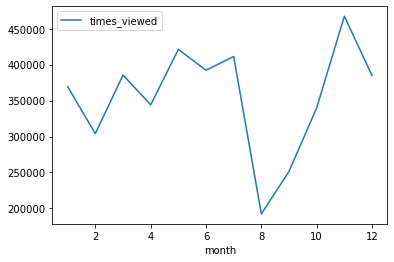

In [25]:
pd.pivot_table(mydf, values = 'times_viewed', index=['month'],aggfunc=np.sum).reset_index().plot("month","times_viewed")

<AxesSubplot:xlabel='year_month'>

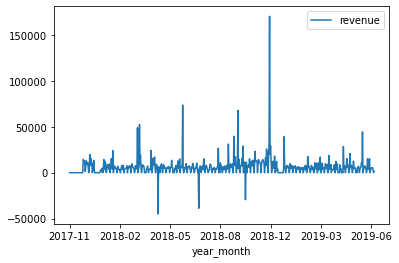

In [26]:
myts.plot("year_month","revenue")

In [27]:
for column in mydf.columns:
    print(column,mydf[column].isnull().sum())


country 0
customer_id 189762
day 0
invoice 0
month 0
price 0
stream_id 0
times_viewed 0
year 0
invoice_date 0


DO a frequency analysis

In [58]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Now, we get the list of dates and the list of corresponding temperatures. The unit is in tenths of a degree, and we get the average value between the minimal and maximal temperature, which explains why we divide by 20.

date = myts.year_month
feat = myts.revenue
N = len(feat)

Text(0, 0.5, 'revenue')

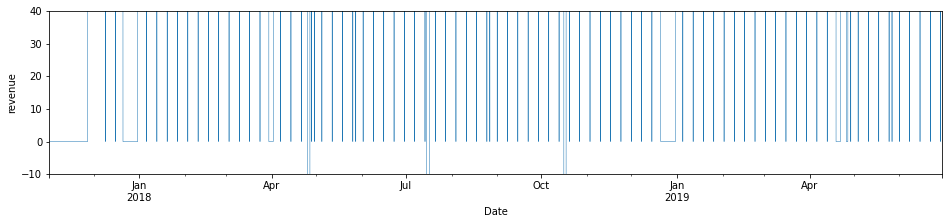

In [59]:
#Let's take a look at the evolution of the choosen feature:

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
feat.plot(ax=ax, lw=.5)
ax.set_ylim(-10, 40)
ax.set_xlabel('Date')
ax.set_ylabel('revenue')

In [34]:
#We now compute the Fourier transform and the spectral density of the signal. The first step is to compute the FFT of the signal using the fft() function:

feat_fft = sp.fftpack.fft(feat)

#Once the FFT has been obtained, we need to take the square of its absolute value in order to get the power spectral density (PSD):

feat_psd = np.abs(feat_fft) ** 2

#The next step is to get the frequencies corresponding to the values of the PSD. The fftfreq() utility function does just that. It takes the length of the PSD vector as input as well as the frequency unit. Here, we choose an annual unit: a frequency of 1 corresponds to 1 year (365 days). We provide 1/365 because the original unit is in days:

fftfreq = sp.fftpack.fftfreq(len(feat_psd), 1. / 7)

#The fftfreq() function returns positive and negative frequencies. We are only interested in positive frequencies here, as we have a real signal:

i = fftfreq > 0


Text(0, 0.5, 'PSD (dB)')

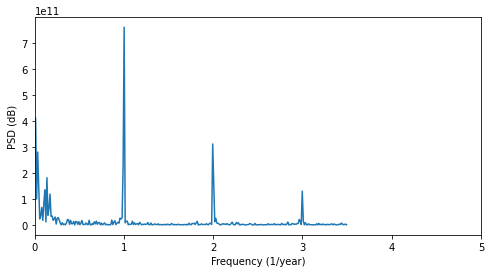

In [35]:
#We now plot the power spectral density of our signal, as a function of the frequency (in unit of 1/year). We choose a logarithmic scale for the y axis (decibels):

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], feat_psd[i])
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/week)')
ax.set_ylabel('PSD (dB)')
#we see a clearly weekly frequency

Feature Engineering

In [36]:
#We will now go ahead and set this column as the index for the dataframe using the set_index() call.
myts = myts.set_index('date')

In [38]:
# At times, it would be essential to extract the month, day of the week, date, etc for each timestamp (i.e. each row of our data). Since we already have the indices set in the DateTime format, extracting these elements become super easy:
# Extract the year, month, date separately using the index set
myts['Year'] = myts.index.year
myts['Month'] = myts.index.month
myts['Week'] = myts.index.week
myts['Weekday_Name'] = myts.index.dayofweek
myts.head(10)

<ipython-input-38-5041df238a90>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  myts['Week'] = myts.index.week


purchases  unique_invoices  unique_streams  total_views  \
date                                                                  
2017-11-01          0                0               0            0   
2017-11-02          0                0               0            0   
2017-11-03          0                0               0            0   
2017-11-04          0                0               0            0   
2017-11-05          0                0               0            0   
2017-11-06          0                0               0            0   
2017-11-07          0                0               0            0   
2017-11-08          0                0               0            0   
2017-11-09          0                0               0            0   
2017-11-10          0                0               0            0   

           year_month  revenue  Year  Month  Week  Weekday_Name  
date                                                             
2017-11-01    2017-11      0.0  2017     11    44             2  
2017-11-02    2017-11      0.0  2017     11    44             3  
2017-11-03    2017-11      0.0  2017     11    44             4  
2017-11-04    2017-11      0.0  2017     11    44             5  
2017-11-05    2017-11      0.0  2017     11    44             6  
2017-11-06    2017-11      0.0  2017     11    45             0  
2017-11-07    2017-11      0.0  2017     11    45             1  
2017-11-08    2017-11      0.0  2017     11    45             2  
2017-11-09    2017-11      0.0  2017     11    45             3  
2017-11-10    2017-11      0.0  2017     11    45             4

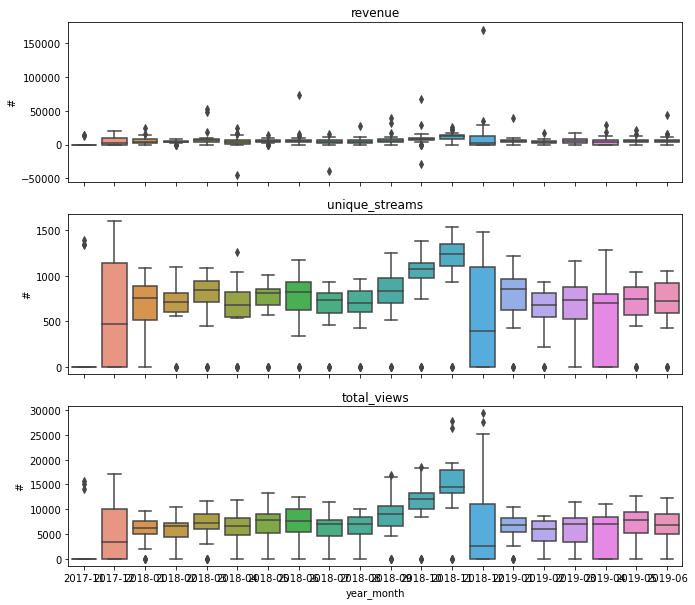

In [42]:
#These additional features can also be useful for exploratory analysis of your dataset. For instance, we can plot the median power consumption for each month.
import seaborn as sns
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['revenue', 'unique_streams', 'total_views'], axes):
    sns.boxplot(data=myts, x='year_month', y=name, ax=ax)
    ax.set_ylabel('#')
    ax.set_title(name)
    # Keep the x-axis label for only the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

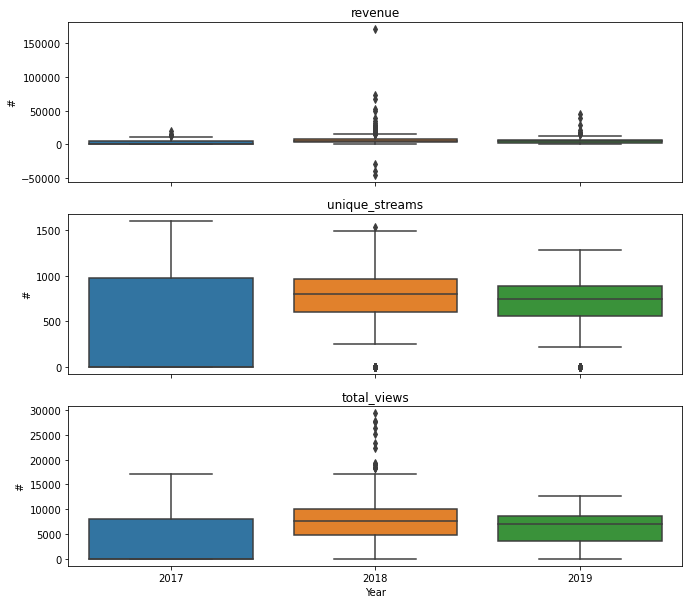

In [41]:
#Same analysis but per year
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['revenue', 'unique_streams', 'total_views'], axes):
    sns.boxplot(data=myts, x='Year', y=name, ax=ax)
    ax.set_ylabel('#')
    ax.set_title(name)
    # Keep the x-axis label for only the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

# Defining the Modeling task
## Goals of Prediction

Our aim is to predict Consumption (ideally for future unseen dates) from this time series dataset.
Training and Test set

We will be using 10 years of data for training i.e. 2006–2016 and last year’s data for testing i.e. 2017.
Performance Measure

In order to evaluate how good our model is, we would be using R-squared and Root Mean Squared Error (but will be printing all relevant metrics for you to take the final call).
Helper Functions

In [81]:
#In order to print all performance metrics relevant to a regression task (such as MAE and R-square), we will be defining the regression_results function.
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


In [91]:
#As a baseline, we choose a simplistic model, one that predicts today’s consumption value based on
#•	yesterday’s revenue value and;
#•	difference between yesterday and the day before yesterday’s consumption value.
# creating new dataframe from consumption column
data_consumption = myts[['revenue']] 
#eliminate negative outliers
data_consumption.loc[data_consumption.revenue < 0, 'revenue'] = 0
# inserting new column with yesterday's consumption values

data_consumption.loc[:,'Prev Week'] = data_consumption.loc[:,'revenue'].shift(7)

# dropping NAs
data_consumption = data_consumption.dropna()
data_consumption.head(60)

/home/alain/Downloads/ENTER/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-91-1330efc994e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_consumption.loc[data_consumption.revenue < 0, 'revenue'] = 0
/home/alain/Downloads/ENTER/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

revenue  Prev Week
date                           
2017-11-08      0.00       0.00
2017-11-09      0.00       0.00
2017-11-10      0.00       0.00
2017-11-11      0.00       0.00
2017-11-12      0.00       0.00
2017-11-13      0.00       0.00
2017-11-14      0.00       0.00
2017-11-15      0.00       0.00
2017-11-16      0.00       0.00
2017-11-17      0.00       0.00
2017-11-18      0.00       0.00
2017-11-19      0.00       0.00
2017-11-20      0.00       0.00
2017-11-21      0.00       0.00
2017-11-22      0.00       0.00
2017-11-23      0.00       0.00
2017-11-24      0.00       0.00
2017-11-25      0.00       0.00
2017-11-26      0.00       0.00
2017-11-27      0.00       0.00
2017-11-28  14450.54       0.00
2017-11-29  13411.96       0.00
2017-11-30  13290.25       0.00
2017-12-01   9687.28       0.00
2017-12-02   1443.26       0.00
2017-12-03   6432.94       0.00
2017-12-04  13137.50       0.00
2017-12-05   9467.01   14450.54
2017-12-06  11268.54   13411.96
2017-12-07  10976.60   13290.25
2017-12-08   4898.32    9687.28
2017-12-09      0.00    1443.26
2017-12-10   4982.87    6432.94
2017-12-11  19866.98   13137.50
2017-12-12  10012.13    9467.01
2017-12-13  15879.66   11268.54
2017-12-14   7701.58   10976.60
2017-12-15  10970.56    4898.32
2017-12-16      0.00       0.00
2017-12-17   1964.79    4982.87
2017-12-18   2846.58   19866.98
2017-12-19  13350.10   10012.13
2017-12-20   2268.31   15879.66
2017-12-21      0.00    7701.58
2017-12-22      0.00   10970.56
2017-12-23      0.00       0.00
2017-12-24      0.00    1964.79
2017-12-25      0.00    2846.58
2017-12-26      0.00   13350.10
2017-12-27      0.00    2268.31
2017-12-28      0.00       0.00
2017-12-29      0.00       0.00
2017-12-30      0.00       0.00
2017-12-31      0.00       0.00
2018-01-01   1966.55       0.00
2018-01-02   3061.27       0.00
2018-01-03    965.85       0.00
2018-01-04   3373.16       0.00
2018-01-05   4979.93       0.00
2018-01-06      0.00       0.00

In [104]:
#Defining training and test sets
X_train = data_consumption['2018'].drop(['revenue'], axis = 1)
y_train = data_consumption.loc['2018', 'revenue']
X_test = data_consumption['2019'].drop(['revenue'], axis = 1)
y_test = data_consumption.loc['2019', 'revenue']
X_train.head(100)

Prev Week
date                 
2018-01-01        0.0
2018-01-02        0.0
2018-01-03        0.0
2018-01-04        0.0
2018-01-05        0.0
...               ...
2018-04-06        0.0
2018-04-07        0.0
2018-04-08        0.0
2018-04-09        0.0
2018-04-10     3875.1

[100 rows x 1 columns]

In [140]:
from sklearn.model_selection import train_test_split
#Defining training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_Rev30,y_rev30,test_size=0.33, shuffle=False)


In [141]:
print(len(X_train), len(y_train))

387 387


In [ ]:
#scaling the data
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train)

X_train=transformer.transform(X_train)
X_test=transformer.transform(X_test)

In [76]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
X_train.describe(include="all")


previous_7    previous_14    previous_28    previous_70  \
count     387.000000     387.000000     387.000000     387.000000   
mean    48872.888858   96834.911979  182086.464915  404279.195248   
std     40727.814247   64959.445285   91421.766023  157981.074024   
min    -24297.079000    5993.670000   14450.540000   14450.540000   
25%     29889.801000   63390.710000  126342.563000  318365.906500   
50%     40008.930000   78401.460000  157265.340000  380820.130000   
75%     60623.366000  126396.310000  221365.410000  452989.238500   
max    292957.640000  377398.580000  516037.181000  907022.712000   

       previous_year  recent_invoices  recent_views  
count     387.000000       387.000000    387.000000  
mean    17326.150189        73.606905   7202.138319  
std     47672.046474        20.569087   2757.085914  
min         0.000000         5.928571    537.392857  
25%         0.000000        63.366667   5916.816667  
50%         0.000000        69.400000   6335.366667  
75%         0.000000        81.100000   7046.050000  
max    198307.760000       123.466667  15843.866667

In [143]:
type(y_train)

numpy.ndarray

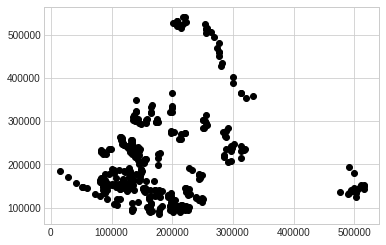

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
x = X_train["previous_28"]
y = y_train
#plt.axis([0, 25000, 0, 25000])
plt.plot(x, y, 'o', color='black');


# Cross-Validation on Time-Series data

A better alternative for cross validation on time series data (than K-fold CV) is Forward Chaining strategy. In forward chaining, say with 3 folds, the train and validation sets look like: • fold 1: training [1], validation [2] • fold 2: training [1 2], validation [3] • fold 3: training [1 2 3], validation [4] where 1, 2, 3, 4 represent the year. This way successive training sets are supersets of those that come before them. Luckily for us, sklearn has a provision for implementing such train test split using TimeSeriesSplit.


LR: -4.254251 (2.730902)


/home/alain/Downloads/ENTER/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/alain/Downloads/ENTER/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


NN: -10.541867 (10.896274)
KNN: -1.178407 (0.590674)
RF: -1.336737 (0.552647)
SVR: -0.836834 (0.808510)


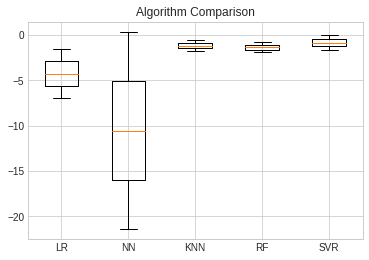

In [149]:
from sklearn.model_selection import TimeSeriesSplit
# Since our training data has 11 unique years (2006 -2016), we would be setting n_splits = 10. This way we have neat training and validation sets

## Spot check Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear# Evaluate each model in turn
results = []
names = []
for name, model in models:    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=2)
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()



In [150]:
print(cv_results)

[-0.02832378 -1.64534331]


In [151]:
#We define our custom scorer as follows:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [152]:
#An optimal combination of hyperparameters maximizes a model’s performance without leading to a high variance problem (overfitting).
#The Python code for performing grid-search is as follows:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
    }
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [154]:
# Checking best model performance on test data
y_true = y_test
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)


explained_variance:  -0.0072
mean_squared_log_error:  0.6297
r2:  -5.066
MAE:  93376.5301
MSE:  10451287539.4812
RMSE:  102231.5389


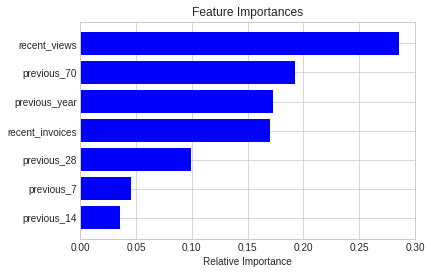

In [155]:
#Variable Importance Plot
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [156]:
print(y_true,y_pred)

[131521.29  134133.25  140815.56  147459.58  152692.77  160245.27
 164240.95  164240.95  166562.67  172752.8   178314.26  184293.11
 183784.64  150880.58  142929.92  137857.52  143213.56  145261.6
 141887.12  140124.43  138111.49  132445.47  127751.59  132126.28
 137656.91  131780.13  133145.43  131491.13  123334.87  119299.03
 136895.7   139856.78  140364.51  138789.02  137063.77  129511.27
 127965.22  135960.62  140898.78  138175.71  138273.34  135549.99
 131732.44  128260.95  139018.93  143552.61  142998.49  141129.8
 147152.34  143689.88  139476.57  143328.26  152610.18  151413.8
 152684.34  165825.79  158015.13  159984.07  162922.83  170591.11
 157772.46  156887.35  155301.41  150232.88  148901.34  158600.75
 165249.26  162394.7   164226.63  165443.92  159784.83  158317.49
 177114.95  180491.66  173503.94  172878.4   177079.46  173355.56
 165990.28  169601.71  171927.77  171098.36  165438.63  170974.741
 162319.071 148046.671 160391.941 162488.031 162787.661 161940.511
 157162.491

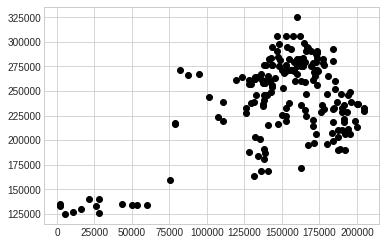

In [157]:
plt.style.use('seaborn-whitegrid')

plt.plot(y_true, y_pred, 'o', color='black');